In [99]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
We used a cressman weight function and bilinear interpolation for three
different passes and calculated differences between the passes to see
if there were improvements.

"""
__author__    = "Ethan Weisberger"
__contact__   = "ethan.weisberger@und.edu"

In [100]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                #pandas
import scipy
from scipy import interpolate as scp

In [101]:
### Read in observations ###
df=pd.read_csv("RAOBs_201903131200.txt", sep=',', names=['station', 'lat', 'lon', 'height', 'winddir', 'windsp'])

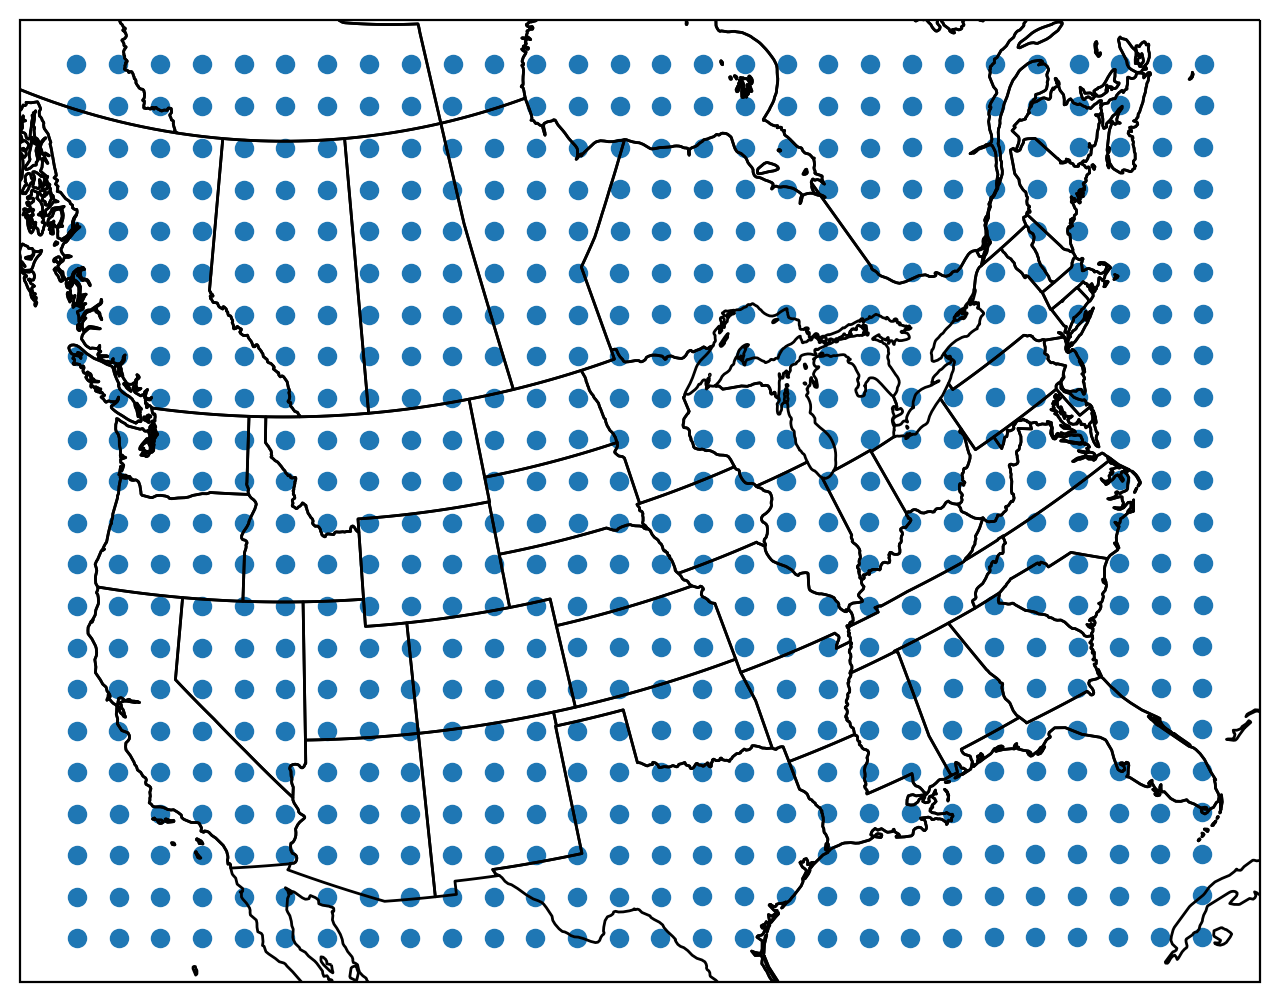

In [102]:
### Set up analysis map with a 22x28 rectangular grid of points ###

#Known Values
map_scale = 1/15000000
rho = 6371*1e5 #radius of Earth
lambda_o = -115 #standard lon
phi_not = 60 * (np.pi/180) #standard lat

#Create 22x28 grid using correct spacing and start locations
x_s=18.9+np.arange(22)*1.27
y_s=-6.3+np.arange(28)*1.27
x,y = np.meshgrid(x_s,y_s)

#Calculate Image Scale
sigma = (1+np.sin(phi_not))/(1+np.sin(df['lat']*np.pi/180))
#Calculate radius of any latitude circle
r=rho*sigma*np.cos(df['lat']*np.pi/180)*map_scale

#Eq from lat/lon to Grid X/Y
y_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/map_scale)**2+(y/map_scale)**2)/(rho*(1+np.sin(phi_not))))))
#print(y_lat)
x_lon = np.arctan(y/x)*(180/np.pi)+lambda_o
#print(lon_y)
xx=r*np.cos(df.lon*(np.pi/180)-lambda_o*(np.pi/180)) #lambda is longitude
yy=r*np.sin(df.lon*(np.pi/180)-lambda_o*(np.pi/180)) #deviation from standard longitude
#print(xx)
xx=np.array(xx)
yy=np.array(yy)

#Plot analysis grid on map
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(x_lon,y_lat, transform=ccrs.PlateCarree())


In [103]:
### Find dmin ###
d_min=[]
for i in range(len(df)):
    a = df.lat[i]-df.lat
    b = df.lon[i]-df.lon
    radius = np.sqrt((xx[i]-xx)**2 + (yy[i]-yy)**2)
    #print(radius)
    dist=np.sort(radius)
    #print(dist)
    d_min.append(dist[1])
    
dmin = sum(d_min)/len(d_min)
print(dmin)

2.5548700820071404


In [104]:
# Define ROIs

R1 = 4 * dmin
R2 = 2.5 * dmin
R3 = 1.5 * dmin

In [105]:
### Create function for Cressman Analysis ###
def cressman(dik, R):
    if dik<=R:
        w_dik_R = ((R)**2-(dik)**2)/(((R)**2+(dik)**2))
        return w_dik_R
    else:
        return 0

In [106]:
### Create function for bilinear interpolation ###

def bilinear(xval,yval,roi):
    rel_x = xval-np.floor(xval) #np.floor rounds down to nearest integer
    rel_y = yval-np.floor(yval)
    
    z1 = fa[int(np.floor(yval)), int(np.floor(xval)), roi]
    z2 = fa[int(np.ceil(yval)), int(np.floor(xval)), roi] #np.ceil rounds up to nearest integer
    z3 = fa[int(np.ceil(yval)), int(np.ceil(xval)), roi]
    z4 = fa[int(np.floor(yval)), int(np.ceil(xval)), roi]
    
    B = ((rel_x-1)*(rel_y-1)*z1)-((rel_x-0)*(rel_y-1)*z2)+((rel_x-0)*(rel_y-0)*z3)-((rel_x-1)*(rel_y-0)*z4)
    return B

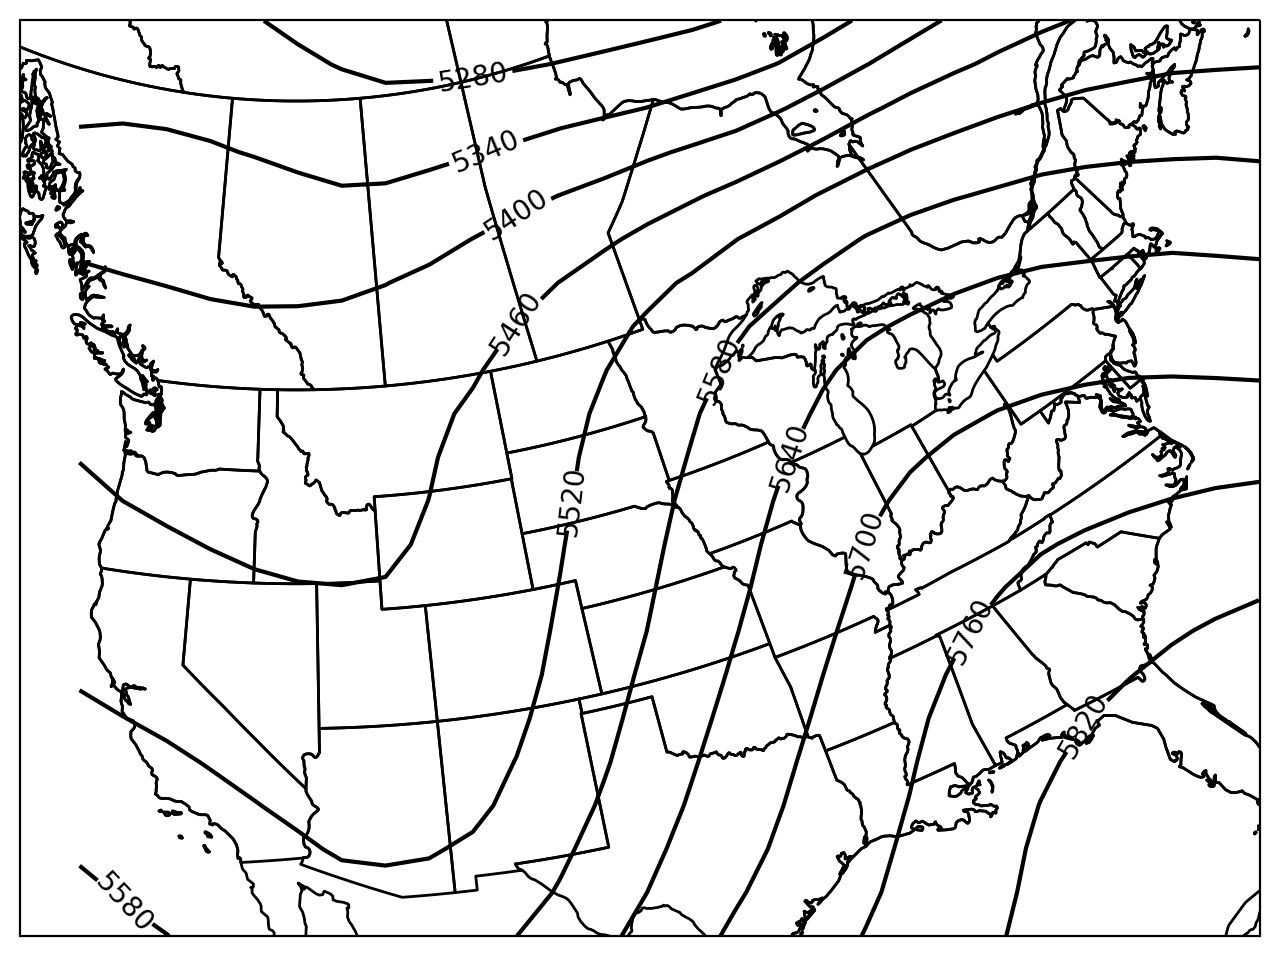

In [107]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###  (First analysis, no successive corrections)

fa= np.zeros((28,22,135))
fo_rk = np.array(df.height)

for j in range(len(x)): #28
    for k in range(len(x[0])):
        xa = x[j,k] - xx
        ya = y[j,k] - yy
        radius = np.sqrt((xa)**2 + (ya)**2)
        idx_array = np.where(radius<=R1)[0]
        weights=np.zeros(len(xa))
        for i in idx_array:
            w = cressman(radius[i], R1)
            weights[i]=w
        fa[j,k,0]= np.sum(weights*fo_rk)/np.sum(weights)
        
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,fa[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('1st_pass.png')

In [108]:
#calc some stuff for bilinear
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi1=np.zeros(len(xx))
#do bilinear interpolation to find the analysis values at observation locations
for i in range(len(obs_rel_x)):
    #check if observation is in grid or outside grid
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],0)
    else:
        xr=xx[i]-x
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R1)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=cressman(radius[j,k],R1)
                weights[j,k]=w
        b=np.sum(weights*fa[:,:,0])/np.sum(weights)
    bi1[i]=b


# calculate RMSE
diff1 = (fo_rk - bi1)**2
diff1 = diff1[~np.isnan(diff1)]
rmse1 = np.sqrt(np.sum(diff1)/len(diff1))
print(rmse1,'m')

# Store analysis in text file
an1 = open('analysis_1st.txt', 'w')
for row in fa[:,:,0]:
    np.savetxt(an1, row)
an1.close()


# Store RMSE in text file
rmse1file = open('rmse_1st.txt', 'w')
rmse1in = str(rmse1)
rmse1file.write(rmse1in)
rmse1file.close()

C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_1624\2891211911.py:20: RuntimeWarning: invalid value encountered in double_scalars
  b=np.sum(weights*fa[:,:,0])/np.sum(weights)


74.5432980040262 m


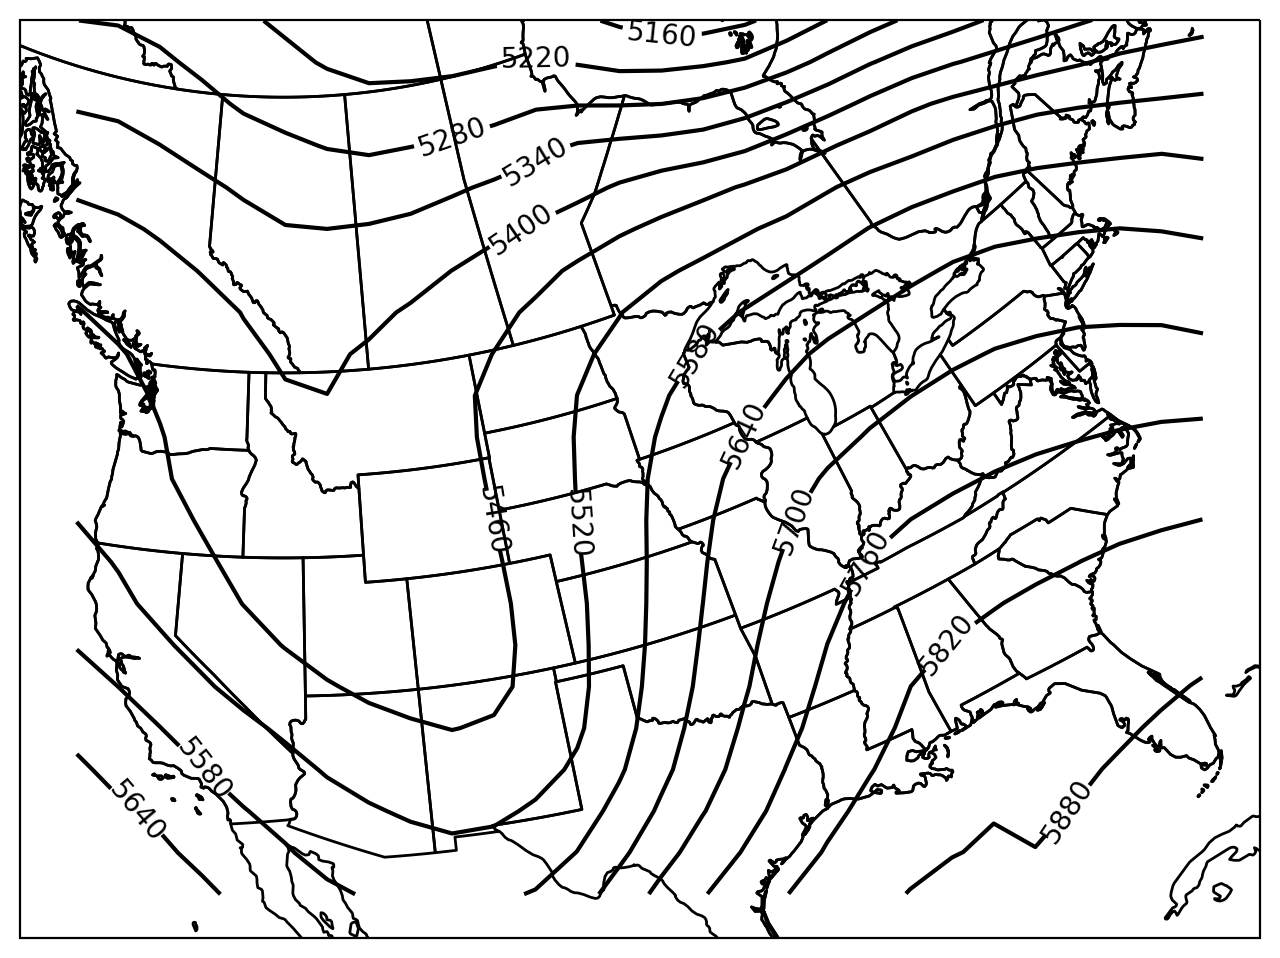

In [109]:
### Next Analyses ### (2nd Pass)

#cressman
for j in range(len(x)):
    for k in range(len(x[0])):
        xr = x[j,k] - xx
        yr = y[j,k] - yy
        radius = np.sqrt((xr**2) + (yr**2))
        idx_array = np.where(radius<=R2)[0]
        weights=np.zeros(len(xr))
        for i in idx_array:
            w = cressman(radius[i], R2)
            weights[i]=w
                 
        fa[j,k,1]= fa[j,k,0] + (np.nansum(weights*(fo_rk-bi1))/np.sum(weights))
        
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,fa[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('2nd_pass.png')

In [110]:
#calc some stuff for bilinear
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi2=np.zeros(len(xx))
#bilinear interpolation
for i in range(len(obs_rel_x)):
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],1)
    else:
        xr=xx[i]-x   #do reverse of before
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R2)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=cressman(radius[j,k],R2)
                weights[j,k]=w
        b=np.sum(weights*fa[:,:,1])/np.sum(weights)
    bi2[i]=b

# calculate RMSE
diff2 = (fo_rk - bi2)**2
diff2 = diff2[~np.isnan(diff2)]
rmse2 = np.sqrt(np.sum(diff2)/len(diff2))
print(rmse2,'m')


# Store analysis in text file
an2 = open('analysis_2nd.txt', 'w')
for row in fa[:,:,1]:
    np.savetxt(an2, row)
an2.close()

# Store RMSE in text file
rmse2file = open('rmse_2nd.txt', 'w')
rmse2in = str(rmse2)
rmse2file.write(rmse2in)
rmse2file.close()


35.12766126581701 m


C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_1624\2500008127.py:19: RuntimeWarning: invalid value encountered in double_scalars
  b=np.sum(weights*fa[:,:,1])/np.sum(weights)


C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_1624\1757116047.py:14: RuntimeWarning: invalid value encountered in double_scalars
  fa[j,k,2]= fa[j,k,1] + (np.nansum(weights*(fo_rk-bi2))/np.sum(weights))


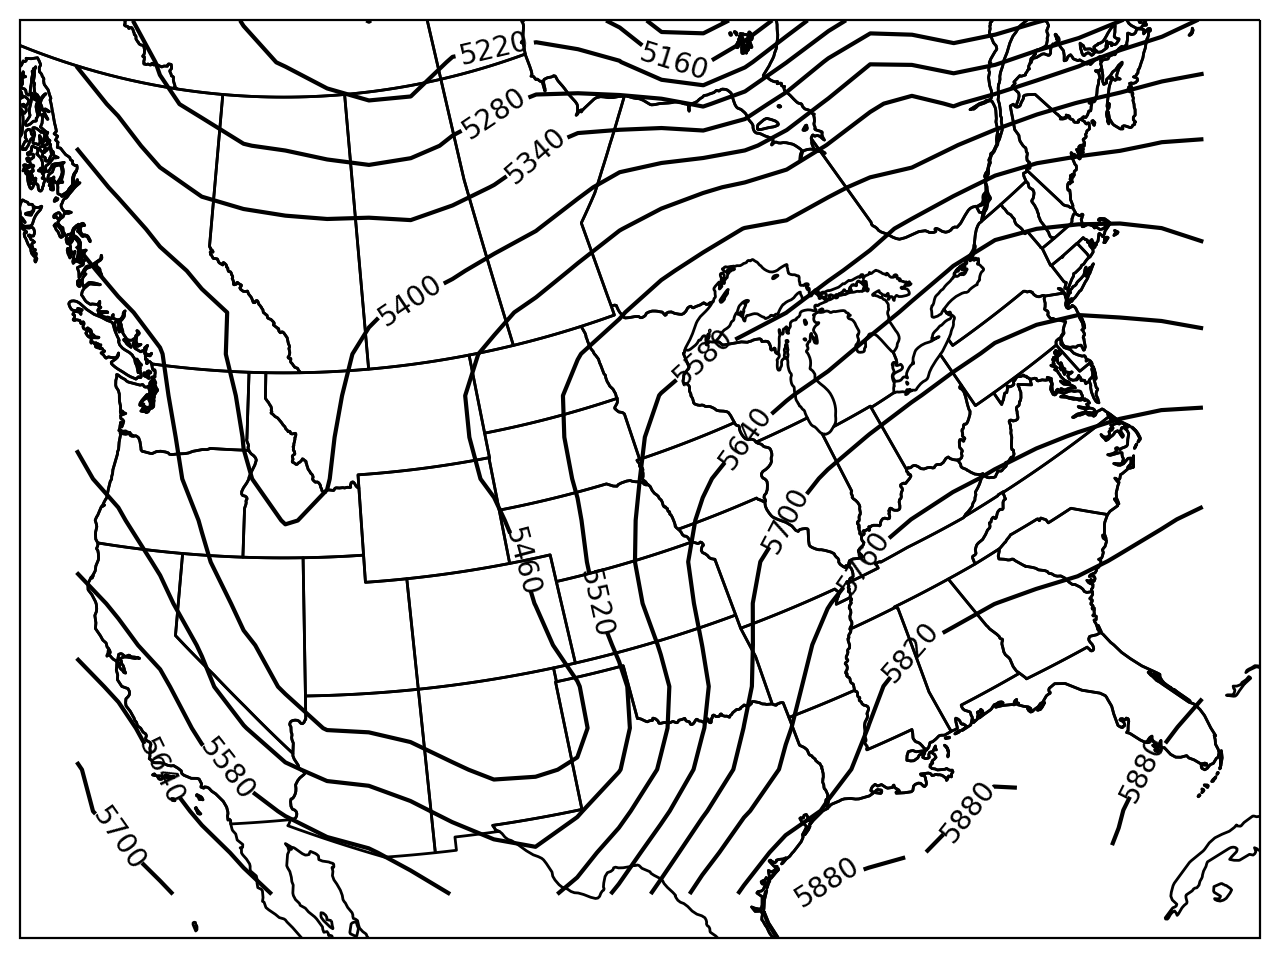

In [111]:
### Next Analyses ###  (3rd Pass)

#cressman
for j in range(len(x)): #28
    for k in range(len(x[0])):
        xr = x[j,k] - xx
        yr = y[j,k] - yy
        radius = np.sqrt((xr**2) + (yr**2))
        idx_array = np.where(radius<=R3)[0]
        weights=np.zeros(len(xr))
        for i in idx_array:
            w = cressman(radius[i], R3)
            weights[i]=w       
        fa[j,k,2]= fa[j,k,1] + (np.nansum(weights*(fo_rk-bi2))/np.sum(weights))
        
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,fa[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('3rd_pass.png')

In [112]:
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi3=np.zeros(len(xx))
#bilinear interpolation
for i in range(len(obs_rel_x)):
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],2)
    else:
        xr=xx[i]-x
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R3)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=cressman(radius[j,k],R3)
                weights[j,k]=w
        b=np.sum(weights*fa[:,:,2])/np.sum(weights)
    bi3[i]=b


# calculate RMSE
diff3 = (fo_rk - bi3)**2
diff3 = diff3[~np.isnan(diff3)]
rmse3 = np.sqrt(np.sum(diff3)/len(diff3))
print(rmse3,'m')

# Store analysis in text file
an3 = open('analysis_3rd.txt', 'w')
for row in fa[:,:,2]:
    np.savetxt(an3, row)
an3.close()

# Store RMSE in text file
rmse3file = open('rmse_3rd.txt', 'w')
rmse3in = str(rmse3)
rmse3file.write(rmse3in)
rmse3file.close()


11.681749880587514 m


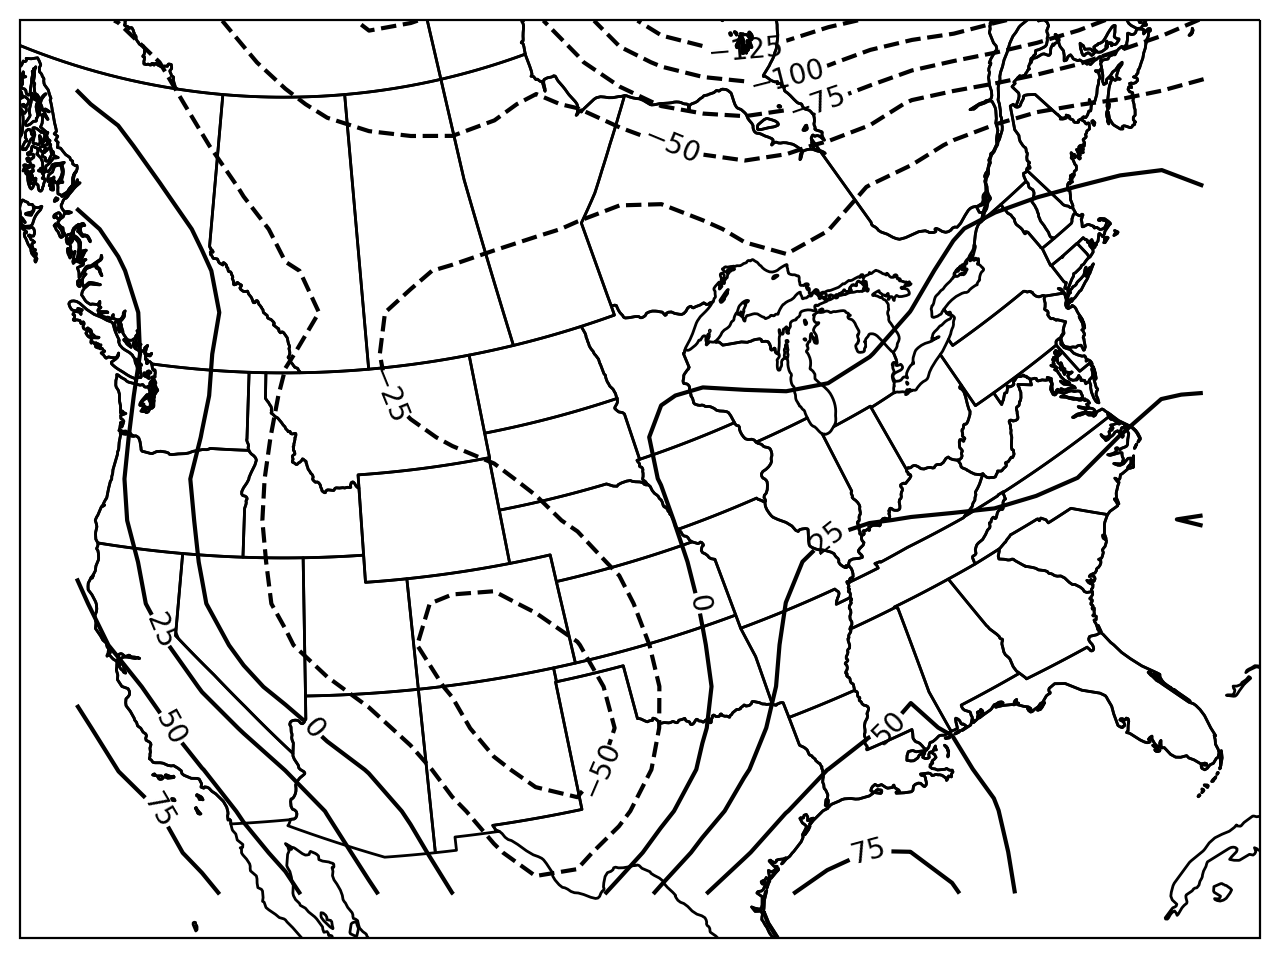

In [113]:
### Calculate Analysis Differences for 2nd pass - 1st pass  and plot ###
diff2_1 = fa[:,:,1]-fa[:,:,0]


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,diff2_1,colors='k',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.savefig('diff_2-1.png')

# Store the difference fields in text file
dif21 = open('diff_2-1.txt', 'w')
for row in diff2_1:
    np.savetxt(dif21, row)
dif21.close()

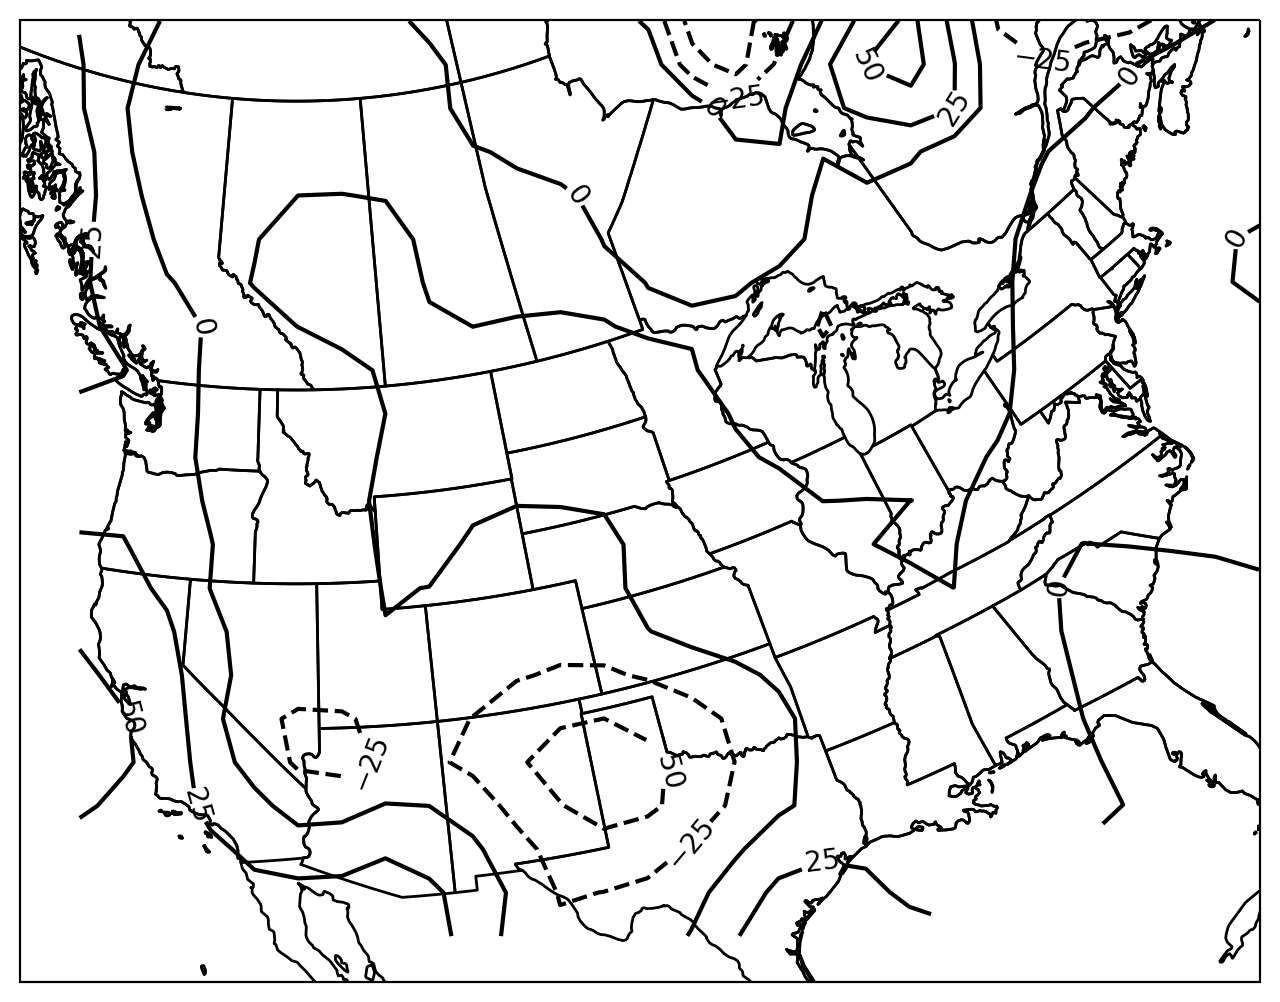

In [114]:
### Calculate Analysis Differences for 3rd pass - 2nd pass ###
diff3_2 = fa[:,:,2]-fa[:,:,1]


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,diff3_2,colors='k',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.savefig('diff_3-2.png')

# Store the difference fields in text file
dif32 = open('diff_3-2.txt', 'w')
for row in diff3_2:
    np.savetxt(dif32, row)
dif32.close()

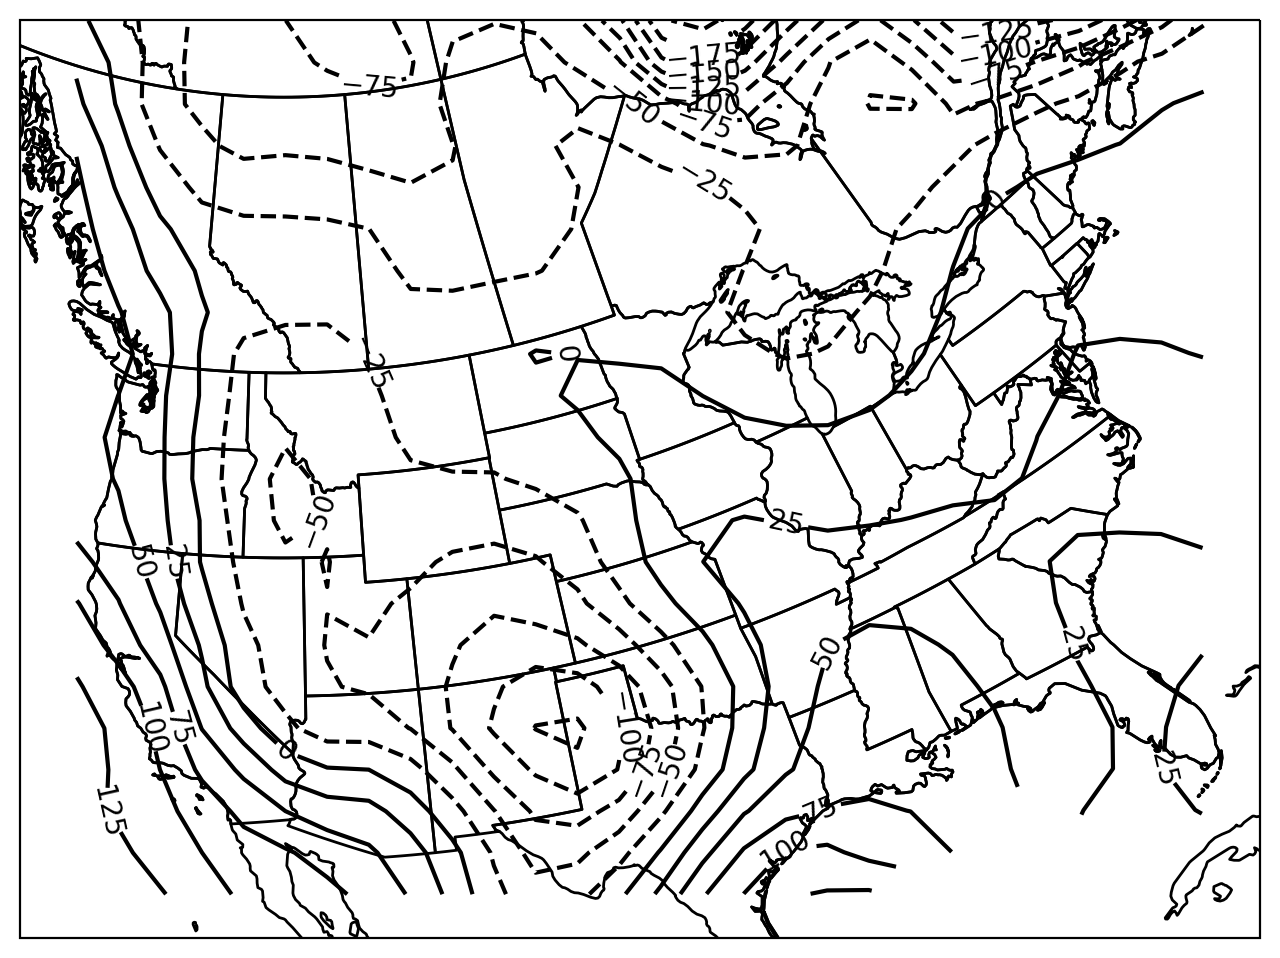

In [115]:
### Calculate Analysis Differences for 3rd pass - 1st pass ###
diff3_1 = fa[:,:,2]-fa[:,:,0]


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,diff3_1,colors='k',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.savefig('diff_3-1.png')

# Store the difference fields in text file
dif31 = open('diff_3-1.txt', 'w')
for row in diff3_1:
    np.savetxt(dif31, row)
dif31.close()

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    For the first pass with no successive corrections, There is a trough over over the 
    western US while there is ridging over the eastern US. For the second pass, there is 
    still the defined ridge and trough pattern, however the trough is deeper with a weird
    sharp feature over Montana and in the Gulf of Mexico. The third pass has an even deeper 
    trough with some sharp turns in the contour analysis over the entire US, while there is
    also some missing data and weird stuff over the Gulf.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    The first pass is much smoother than the second, and especiialy the third. This is because
    the first pass analysis is getting the large scale features and smoothing out/ignoring
    the small scale stuff. The more passes you do the more smaller scale features end up showing
    up. 
    
    Sort of repeated what was said in question 1, the differences between the first and second pass is 
    best seen in the trough strength and position where pass 2 has a deeper and more negatively tilted trough.
    Pass three has a deeper trough than both pass two and one where the 5460 contour extends deep into southern
    NM and the 5400 contour extends into Idaho.

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    
    Man, I am kind of answering these questions in my answers to the previous ones haha. So sort of
    reiterating what I said above, the more passes you do the more small scale features like shortwaves 
    and variablility between observations start showing up whereas the first pass only gives the smoother
    and large scale features. This is advantageous depening on what you are interested in studying. If you
    only care about the large synoptic pattern a small number of passes is best, but if you want to look at some
    finer features emebeded in the flow then doing more passes may be better.
    

'''